### Assignment : Week 3
## Efficiently finding optimal policies in MABs

In this assignment, we will work with Multi Armed Bandit environments, and try to find the best policies using different strategies to minimize the total regret.

The aim of this exercise is to code agents capable of understanding the underlying probability distributions of the environment and finding the most optimal actions as early as possible.

You can start this assignment during/after reading Grokking Ch-4.

Let's get started!

In [81]:
# importing necessary stuff
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

# if you want to use envs from Gym, import it
import gym,gym_walk
from gym.envs.toy_text.frozen_lake import generate_random_map

Let's make a simple **2-armed Bernoulli** bandit.

If you want a cleaner code, you can implement Bandits using `class` in Python.

We have included sample code for this in `bandits.py` which you can take/import.

In [27]:
# generating the underlying probability distribution

probs = np.random.random(2)

In [28]:
# our MDP is a function which takes an action and returns a reward

def mab_2_env(action):
    gen = np.random.random()

    # for bernoulli bandits, the reward is 1 if the random number is less than the probability of success, else 0
    return gen < probs[action]

Let's now make a template for testing different strategies.

Feel free to modify this code.

In [29]:
# strategy function takes in the environment function, number of actions, and a selector function
# it also takes in the number of episodes to run the strategy for (higher episodes = more accurate Q values)

def test_strategy(env, n_actions, selector, n_episodes = 1000):
    
    # initialize Q and N to 0s
    Q = np.zeros(n_actions)
    N = np.zeros(n_actions)

    # loop for n_episodes
    for e in tqdm(range(n_episodes)):
        
        # selector function takes in current Q and returns an action
        # modify the selector function according to the strategy
        action = selector(Q)

        # get the reward from the environment
        reward = env(action)

        # update N and Q
        N[action] += 1
        Q[action] += (reward - Q[action])/N[action]

    # return the best action
    return np.argmax(Q)

Implementing the simplest selector using pure-exploration strategy.

In [30]:
# selector returns a random action
random_selector = lambda Q : np.random.randint(len(Q))

Let's test this strategy.

In [31]:
test_strategy(mab_2_env, 2, random_selector)

  0%|          | 0/1000 [00:00<?, ?it/s]

1

As you can see, it returns the optimal action. Let's check if that's indeed true.

We can do that by revealing the actual `probs` distribution.

In [32]:
probs

array([0.73626188, 0.82056703])

As expected, our pure exploration strategy does indeed return the optimal action for this Bernoulli bandit. 

You can try generating new bandits with different `probs` and try out the same.

With all this in place, here's what you have to do -

Recall that, the regret $\mathcal{T}$ is given by,

$$\mathcal{T}=\sum  _{e=1} ^{E} \mathbb{E} \left[ v_* - q_* \left( A_e \right) \right]$$

We can only calculate it when we have the $v_*$ and $q_*$ functions known beforehand. Since we are making the MDPs from scratch, that's not an issue for us right now.

But remember, in real-life problems, these functions are not known. Hence we must be aware of multiple policy finding strategies and try the one which gives best results fastest.

### Todo 0

Implement the calculation of the total regret $\mathcal{T}$ for your strategy.

To do this, you will need to store the rewards obtained each episode. Modify the `strategy` function accordingly.

In [56]:
# function to calculate total regret

def regret(rewards, probs):
    optimal_index=np.argmax([reward * prob for reward, prob in zip(rewards, probs)])
    optimal_payoff = rewards[optimal_index]
    individual_regrets = [optimal_payoff - reward for reward in rewards]
    total_regret = np.sum(individual_regrets)
    
    
    return total_regret

rewards = [10, 8, 5, 12]
probabilities = [0.2, 0.3, 0.1, 0.4]

result = regret(rewards, probabilities)
print(f"Total Regret: {result}")

Total Regret: 13


### Todo 1

Now, let's implement some other selection strategies and compare their regret with the simple exploration strategy.

Note that some of these strategies involve hyperparameter(s) which need to be manually adjusted. You have to play around with the values and see which one gives you best results.

This is known as "hyperparameter tuning" and is quite commonly done while working with complex models (including neural networks). Personally, you should try out some natural values (including the ones given in the book) along with some extreme values where it is easy to manually verify the correctness of your strategy.

In [48]:
# epsilon-greedy strategy
# Already implemented for you coz I am nice

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(len(Q))
    else:
        return np.argmax(Q)

In [35]:
# exponentially decaying epsilon greedy strategy

def exponentially_decaying_epsilon_greedy(Q, epsilon, episode):
    
    # implement the exponentially decaying epsilon greedy strategy here
    decay_ratio=0.1
    min_epsilon=0.01
    decay_episodes=int(episode*decay_ratio)
    rem_episodes=episode-decay_episodes
    epsilons=0.01
    epsilons/=np.logspace(-2,0,decay_episodes)
    epsilons*=epsilon-min_epsilon
    epsilons+=min_epsilon
    epsilons=np.pad(epsilons,(0,rem_episodes),'edge')
    for e in tqdm(range(episode)):
        if np.random.random()>epsilons[e]:
            return np.argmax(Q)
        else:
            return np.random.randint(len(Q))

    raise NotImplementedError()

In [36]:
# softmax action selection strategy

def softmax_strategy(Q, temperature):
    
    # implement the softmax strategy here
    decay_ratio=0.04
    episodes=5000
    min_temperature=0.01
    for e in tqdm(range(episodes)):
        decay_episodes=episodes*decay_ratio
        temp=1-e/decay_episodes
        temp*=temperature-min_temperature
        temp+=min_temperature
        temp=np.clip(temp,min_temperature,temperature)
        
        scaled_Q=Q/temp
        norm_Q=scaled_Q-np.max(scaled_Q)
        exp_Q=np.exp(norm_Q)
        probs=exp_Q/np.sum(exp_Q)
        
        assert np.isclose(probs.sum(),1.0)
        action=np.random.choice(np.arange(len(probs)), size=1,p=probs)[0]
    return action
    raise NotImplementedError()

In [37]:
# upper confidence bound strategy

def ucb(Q, N, c):
    
    # implement the ucb strategy here
    for e in tqdm(range(N)):
        if e<len(Q):
            action=e
        else:
            U=np.sqrt(c*np.log(e)/N)
            action=np.argmax(Q+U)
    return action

    raise NotImplementedError()

In [38]:
# thompson sampling strategy

def thompson_sampling(Q, N, alpha, beta):
    
    # implement the thompson sampling strategy here
    for e in tqdm(range(N)):
        samples=np.random.normal(loc=Q,scale=alpha/(np.sqrt(N)+beta))
        action=np.argmax(samples)
    return action

    raise NotImplementedError()

### Todo 2

Run each strategy for 2-armed bandit environment and compare the total regrets.

You can also try plotting the regret vs episode graph and check if it matches the expected result from Grokking

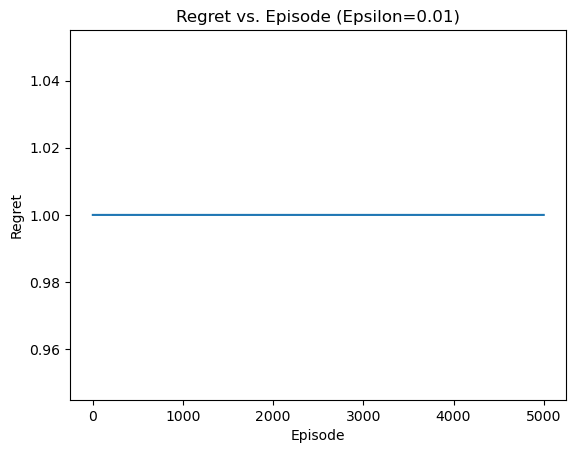

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

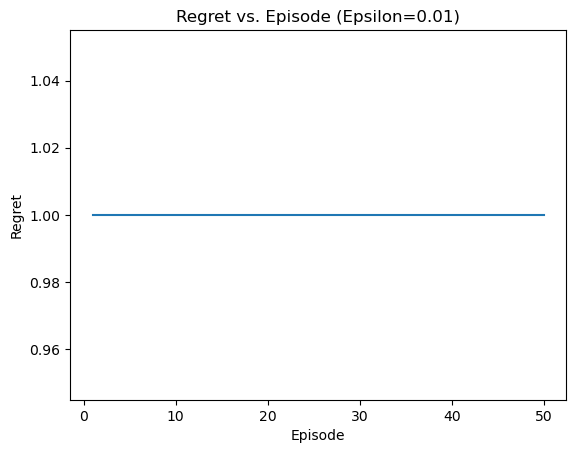

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

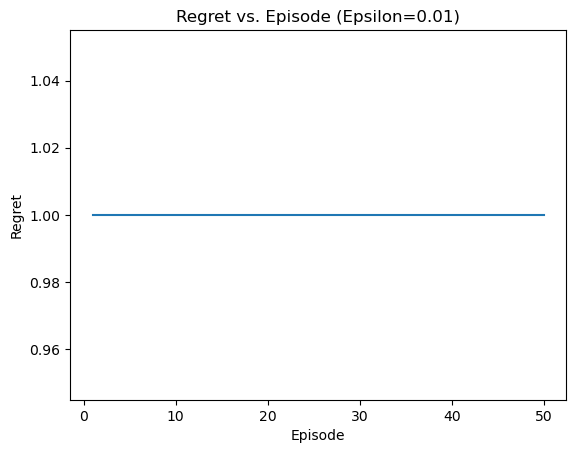

In [77]:
# import plotting libraries
env = gym.make('SlipperyWalkFive-v0')
Q=np.full((env.action_space.n),1.0,dtype=np.float64)

import matplotlib.pyplot as plt
def show_plot(regret_list,num_episodes,epsilon):
    plt.plot(range(1, num_episodes + 1), regret_list)
    plt.xlabel("Episode")
    plt.ylabel("Regret")
    plt.title(f"Regret vs. Episode (Epsilon={epsilon})")
    plt.show()
    
#testing epsilon_greedy
episodes=5000
regret_list1=list()
for e in range(episodes):
    actions=epsilon_greedy(Q,0.07)
    reward=mab_2_env(actions)
    reward_list1=[int(reward),int(not reward)]
    p=np.random.random(1)
    prob_d=[p,1-p]
    regret_list1.append(regret(reward_list,prob_d))

show_plot(regret_list1,episodes,0.01)

#testing exponentially_decaying_epsilon_greedy

episodes=50
regret_list2=list()
for e in range(episodes):
    actions=exponentially_decaying_epsilon_greedy(Q,0.1,episodes)
    reward=mab_2_env(actions)
    reward_list2=[int(reward),int(not reward)]
    p=np.random.random(1)
    prob_d=[p,1-p]
    regret_list2.append(regret(reward_list,prob_d))

show_plot(regret_list2,episodes,0.01)

#testing softmax strategy

episodes=50
regret_list3=list()
for e in range(episodes):
    actions=softmax_strategy(Q,0.1)
    reward=mab_2_env(actions)
    reward_list3=[int(reward),int(not reward)]
    p=np.random.random(1)
    prob_d=[p,1-p]
    regret_list3.append(regret(reward_list,prob_d))

show_plot(regret_list3,episodes,0.01)

#testing ucb
episodes=50
regret_list4=list()
for e in range(episodes):
    actions=ucb(Q,episodes,2)
    reward=mab_2_env(actions)
    reward_list4=[int(reward),int(not reward)]
    p=np.random.random(1)
    prob_d=[p,1-p]
    regret_list4.append(regret(reward_list,prob_d))

show_plot(regret_list4,episodes,0.2)

#testing thompson_sampling
episodes=50
regret_list5=list()
for e in range(episodes):
    actions=thompson_sampling(Q,episodes,1,0)
    reward=mab_2_env(actions)
    reward_list5=[int(reward),int(not reward)]
    p=np.random.random(1)
    prob_d=[p,1-p]
    regret_list5.append(regret(reward_list,prob_d))

show_plot(regret_list5,episodes,0.01)

### Todo 3

The 2-armed bandits might be too simple for us to actually see substantial difference in the regret of these strategies. 

Let's now create a more complicated bandit environment and replicate our results on it.

We will now implement a 10-armed Gaussian bandit. 

As required, it will have possible actions and each action will generate a reward sampled from a Gaussian distribution.

Hence, each "arm" will have a randomly generated $\mu$ and $\sigma$, and the rewards will be generated with probabilities following the $\mathcal{N}(\mu, \sigma^2)$ distribution. 

In [53]:
# 10 arm gaussian bandit

# generate the means for each arm
means = []

# generate the variance for each arm
variances = []

In [23]:
# our MDP is a again function which takes an action and returns a reward

def mab_10_env(action):
    # for gaussian bandits, the reward is generated from a normal distribution
    gen=np.random.random()
    return gen < probs[action]
    
    raise NotImplementedError()

### Todo 4

Test the different strategies on the 10-armed gaussian bandit and verify your results.